Some data was collected prior writing this report. For example,
`./data/sites_published` has the output `aws s3 ls` for the `publisherstore-us`
bucket that contains archives of the published websites. In addition,
`./data/sites_to_copy.csv` contains site ids that needs to be republished. At
the moment, SQL query for them looks like that:

```sql
select distinct sps.id
from sites_publishedsite sps
		 join (select *
			   from sites_sitereplicant outer_
			   where not exists(select 1
								from sites_sitereplicant inner_
								where inner_.id = outer_.id
								  and inner_.store_id in %s)) ssr
			  on ssr.published_site_id = sps.id
		where sps.disabled = 0
			and sps.state = 0
			and date_published >= DATE '2018-08-01'
```

Let's prepare our data. We will select ZIP files from the bucket.

In [1]:
# !pv ./data/sites_published | grep .zip | \
# 	awk '{gsub(".zip$", "", $4);print $4}' > \
# 	./data/transformed/sites_published_zips.csv

Here is how look ids of the sites that we need to copy

In [2]:
import pandas as pd
# import modin.pandas as pd
sites_to_copy = pd.read_csv(
	'./data/sites_to_copy.csv', names=['site_to_copy_ids'])
sites_to_copy.head()

,site_to_copy_ids
0,0000201ae82e4b1293c860235894200f
1,00003b1c0f064827bdc7e0397139dc93
2,000047159c254c06848660d03a72f038
3,00008a6f271548ff9a6274620c7bd6cc
4,0000a6c1778a44d1a0687266a94f00a9


There are plenty of them:

In [3]:
sites_to_copy.count()

site_to_copy_ids    359165
dtype: int64

Here is how look ids of the artifacts in the S3

In [4]:
sites_published_zips = pd.read_csv(
	'./data/transformed/sites_published_zips.csv',
	names=['site_published_zips'])
sites_published_zips.head()

,site_published_zips
0,00001f94c5c54973b5539aca547f48cf
1,0000201ae82e4b1293c860235894200f
2,0000237a29ef4155a731cac18e3425a5
3,0000252074964f219d47ea136ffef019
4,00002f6e7c274081873af579c80e3a25


Is there any site without an archive?

In [5]:
set_sites_published_zips = set(
	sites_published_zips['site_published_zips'].values.tolist())
set_sites_to_copy = sites_to_copy[ 'site_to_copy_ids'].values.tolist()
diff = set(set_sites_to_copy).difference( set_sites_published_zips)


print(bool(diff))

True


Really? Give an example please.

In [6]:
import random
random.sample(diff, 10)

['9e16165044c8445ab8d396318a5dae8c',
 'a45a4638e59741ec90b6dcab7a2dbf9c',
 'a55279f3f416418e981383b392aad650',
 '9bd7bc07e1884b71b8cc12256faf4e0f',
 '44fcd85f801b4893a72202c7600f2522',
 '068c97a3742c49dbbdf1d7a78fff47f2',
 'f182f7a9da7d42b0aaac219eda346bf5',
 '115c578e613a4925ab8de35edc61e4cf',
 'e3c631497ad441d0a0ce35e88f6b8fd2',
 'c967f95e62d04f70a4b2fa0cf4943cdc']

How many?

In [7]:
print('Total: %s' % len(diff))

Total: 10673


Ok, let's prepare our data, but this time we will include object
 creation date.

In [8]:
# !pv ./data/sites_published | grep .zip | \
# 	awk '{gsub(".zip$", "" ,$4); print $4 "," $1 "T" $2 "Z"}' > \
# 	./data/transformed/sites_published_zips_with_dates.csv

Archives and their creation dates(a-la CSV).

In [9]:
!head -n 5 ./data/transformed/sites_published_zips_with_dates.csv

00001f94c5c54973b5539aca547f48cf,2016-03-09T19:07:12Z
0000201ae82e4b1293c860235894200f,2020-10-05T06:02:05Z
0000237a29ef4155a731cac18e3425a5,2017-11-07T05:16:45Z
0000252074964f219d47ea136ffef019,2016-06-23T07:29:33Z
00002f6e7c274081873af579c80e3a25,2015-11-05T21:27:35Z


Sites and their publishing dates(CSV).

In [10]:
!head -n 5 ./data/sites_to_copy_with_dates.csv

0000201ae82e4b1293c860235894200f,2020-10-05T06:02:04Z
00003b1c0f064827bdc7e0397139dc93,2019-05-26T06:45:48Z
000047159c254c06848660d03a72f038,2020-02-14T17:07:26Z
00008a6f271548ff9a6274620c7bd6cc,2020-05-14T21:40:34Z
0000a6c1778a44d1a0687266a94f00a9,2019-01-23T17:21:25Z


In [11]:
sites_to_copy_with_dates = pd.read_csv(
	'./data/sites_to_copy_with_dates.csv',
	names=['site_to_copy_ids', 'site_published_date'],
	parse_dates=['site_published_date']
).set_index('site_to_copy_ids')

In [12]:
sites_published_zips_with_dates = pd.read_csv(
	'./data/transformed/sites_published_zips_with_dates.csv',
	names=['site_published_zips_ids', 's3_object_published_date'],
	parse_dates=['s3_object_published_date']
).set_index('site_published_zips_ids')

We can join sites and archives on id

In [13]:
dates_joined = sites_to_copy_with_dates.join(
	sites_published_zips_with_dates, lsuffix='l_', rsuffix='r_')
dates_joined.head()

,site_published_date,s3_object_published_date
site_to_copy_ids,,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00,2020-10-05 06:02:05+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00,2019-05-26 06:45:49+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00,2020-02-14 17:07:26+00:00
00008a6f271548ff9a6274620c7bd6cc,2020-05-14 21:40:34+00:00,2020-05-14 21:40:35+00:00
0000a6c1778a44d1a0687266a94f00a9,2019-01-23 17:21:25+00:00,2019-01-23 17:21:25+00:00


Let's calculate the timedelta between two publishing dates.

In [14]:
dates_joined['timedelta'] = (dates_joined['s3_object_published_date']
	- dates_joined['site_published_date'])

In [15]:
dates_joined.sort_values('timedelta')

,site_published_date,s3_object_published_date,timedelta
site_to_copy_ids,,,
8a49866b2966498601298fd5da6f26c9,2020-11-18 13:55:26+00:00,2010-09-04 21:18:15+00:00,-3728 days +07:22:49
8a49866b2a910c98012a96734c144cbe,2020-11-18 13:55:48+00:00,2010-09-09 17:10:09+00:00,-3723 days +03:14:21
8a49866a2af939b8012afaf34d3a118c,2020-11-18 13:43:41+00:00,2010-09-10 10:01:53+00:00,-3723 days +20:18:12
8a49866a2afe125c012b094dfba27d42,2020-11-11 12:41:20+00:00,2010-09-13 05:19:18+00:00,-3713 days +16:37:58
8a4986cb2b8aa1a7012b9b38f7121aa7,2020-11-18 13:56:03+00:00,2010-10-11 12:17:31+00:00,-3692 days +22:21:28
...,...,...,...
ffefac401f764344be62136a24762b2b,2019-03-21 17:56:01+00:00,NaT,NaT
fff25cfce17b4ef1944e9a5ffa7c158f,2019-03-25 20:49:20+00:00,NaT,NaT
fff2f61e5b9e4306a7d078ad2f4982b6,2020-11-09 11:15:17+00:00,NaT,NaT


In [16]:
no_na = dates_joined.sort_values('timedelta').dropna()
short_discrepancy = no_na[(no_na['timedelta'] > pd.Timedelta(days=1))
	  | (no_na['timedelta'] < pd.Timedelta(days=-1))]

How many sites have publishing date discrepancy with their S3 object?
Also, exclude sites that miss archive completely.

In [17]:
short_discrepancy.count()

site_published_date         7065
s3_object_published_date    7065
timedelta                   7065
dtype: int64

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
discrepancy_dates = short_discrepancy.apply(
	lambda row: row.site_published_date.date(), axis='columns')

In [20]:
discrepancy_dates.value_counts()

2020-11-17    779
2020-11-18    697
2020-11-16    573
2020-11-12    437
2020-11-10    434
             ... 
2020-09-23      1
2019-06-09      1
2020-09-28      1
2020-02-10      1
2020-03-19      1
Length: 74, dtype: int64

Show please when happened discrepancies between site publish data and S3 object
 creation timestamp.

<AxesSubplot:xlabel='Date', ylabel='Discrepancy Publish Count'>

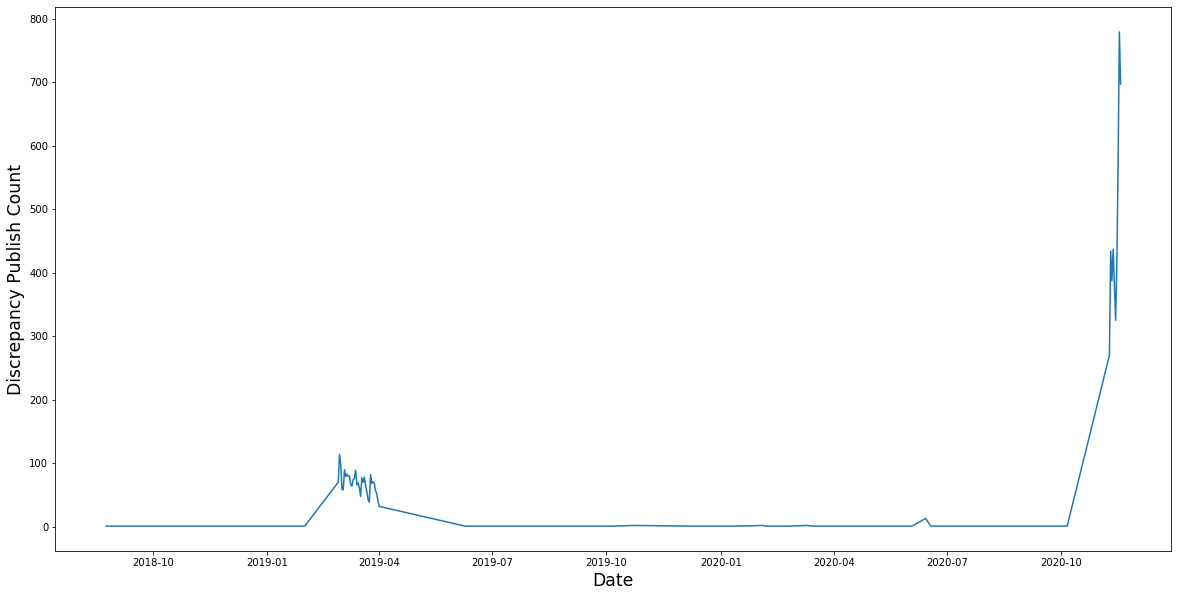

In [21]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Discrepancy Publish Count', **{'fontsize': 'xx-large'})
discrepancy_dates.value_counts().plot()

Now let's find more info about the absent artifacts. Show please the count of
 sites with absent artifacts per site publishing date.

In [22]:
absent_values = dates_joined[
	dates_joined['s3_object_published_date'].isna()
	& (dates_joined['site_published_date'] < pd.Timestamp(
		'2020-11-01T00:00Z'))]
absent_dates = absent_values.apply(
	lambda row: row.site_published_date.date(), axis='columns'
)
absent_dates.value_counts()
pass

<AxesSubplot:xlabel='Date', ylabel='Count of absent artifacts'>

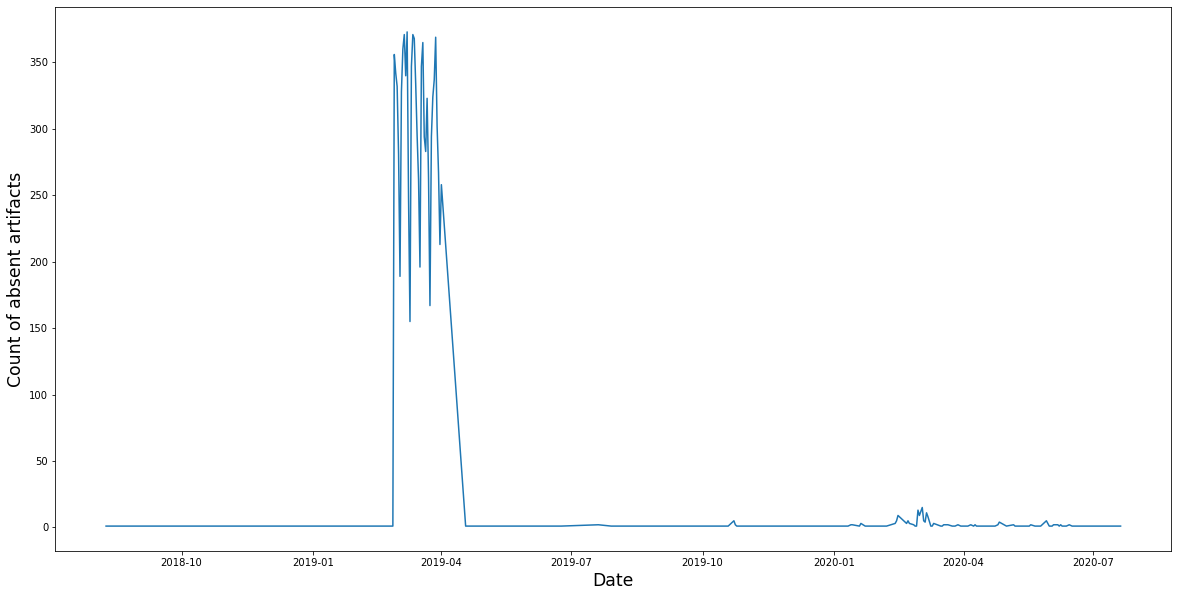

In [23]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Count of absent artifacts', **{'fontsize': 'xx-large'})
absent_dates.value_counts().plot()

The same plot, but Y-axis log scale, please?

<AxesSubplot:xlabel='Date', ylabel='Count of absent artifacts, log scale'>

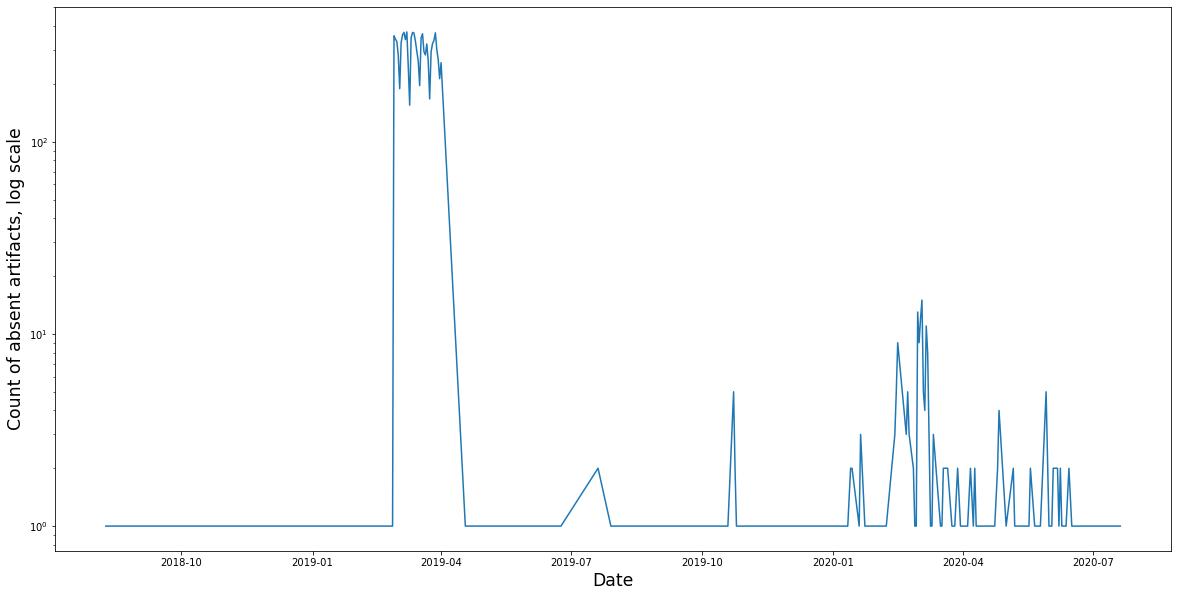

In [24]:
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Count of absent artifacts, log scale', **{'fontsize': 'xx-large'})
absent_dates.value_counts().plot()

By the way, how many artifacts are absent before we started the work
 on this ticket?

In [25]:
absent_values.count()

site_published_date         10485
s3_object_published_date        0
timedelta                       0
dtype: int64

What if we dig deeper and check discrepancies in publishing for a longer period
 of time?

In [26]:
# !pv ./data/all_published_sites_and_their_dates.csv | \
# 	awk '{print $1 "T" $2 "Z"}' > \
# 	./data/transformed/all_published_sites_and_their_dates.csv

In [27]:
! head -n 5  ./data/transformed/all_published_sites_and_their_dates.csv

0000201ae82e4b1293c860235894200f,2020-10-05T06:02:04Z
0000237a29ef4155a731cac18e3425a5,2017-11-07T05:16:42Z
0000252074964f219d47ea136ffef019,2016-06-23T07:29:33Z
00003b1c0f064827bdc7e0397139dc93,2019-05-26T06:45:48Z
000047159c254c06848660d03a72f038,2020-02-14T17:07:26Z


In [28]:
all_sites_with_dates = pd.read_csv(
	'./data/transformed/all_published_sites_and_their_dates.csv',
	names=['site_id', 'site_published_date'],
	parse_dates=['site_published_date']
).set_index('site_id')


In [29]:
all_sites_with_dates.head()

,site_published_date
site_id,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00
0000237a29ef4155a731cac18e3425a5,2017-11-07 05:16:42+00:00
0000252074964f219d47ea136ffef019,2016-06-23 07:29:33+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00


In [30]:
all_sites_artifacts_joined = all_sites_with_dates.join(
	sites_published_zips_with_dates)
all_sites_artifacts_joined.head()

,site_published_date,s3_object_published_date
site_id,,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00,2020-10-05 06:02:05+00:00
0000237a29ef4155a731cac18e3425a5,2017-11-07 05:16:42+00:00,2017-11-07 05:16:45+00:00
0000252074964f219d47ea136ffef019,2016-06-23 07:29:33+00:00,2016-06-23 07:29:33+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00,2019-05-26 06:45:49+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00,2020-02-14 17:07:26+00:00


In [31]:
all_sites_artifacts_joined['timedelta'] = (
	all_sites_artifacts_joined['s3_object_published_date']
		- all_sites_artifacts_joined['site_published_date'])

In [32]:
all_sites_artifacts_joined.sort_values('timedelta')

,site_published_date,s3_object_published_date,timedelta
site_id,,,
8a49866b2966498601298fd5da6f26c9,2020-11-18 13:55:26+00:00,2010-09-04 21:18:15+00:00,-3728 days +07:22:49
8a49866b2a910c98012a96734c144cbe,2020-11-18 13:55:48+00:00,2010-09-09 17:10:09+00:00,-3723 days +03:14:21
8a49866a2af939b8012afaf34d3a118c,2020-11-18 13:43:41+00:00,2010-09-10 10:01:53+00:00,-3723 days +20:18:12
8a49866a2afe125c012b094dfba27d42,2020-11-11 12:41:20+00:00,2010-09-13 05:19:18+00:00,-3713 days +16:37:58
8a4986cb2b8aa1a7012b9b38f7121aa7,2020-11-18 13:56:03+00:00,2010-10-11 12:17:31+00:00,-3692 days +22:21:28
...,...,...,...
ffee42d6549a4a17b99e66e655361b27,2019-02-27 06:58:56+00:00,NaT,NaT
ffefac401f764344be62136a24762b2b,2019-03-21 17:56:01+00:00,NaT,NaT
fff25cfce17b4ef1944e9a5ffa7c158f,2019-03-25 20:49:20+00:00,NaT,NaT


In [33]:
all_no_na = all_sites_artifacts_joined.dropna()
all_discrepancies_dates = all_no_na[
	(all_no_na['timedelta'] > pd.Timedelta(days=1))
	  | (all_no_na['timedelta'] < pd.Timedelta(days=-1))]

In [34]:
import swifter  # noqa
# swifter.register_modin()
all_discrepancies_dates = all_discrepancies_dates.swifter.apply(
	lambda row: row.site_published_date.date(), axis='columns'
)
all_discrepancies_dates.head()

site_id
00007d414a464399a0981fd0681c5bcd    2015-03-29
00007df545da4f52ab49a453dc537250    2015-02-18
0000d400fc444267a54cf40bf089eafd    2015-03-28
0001ba217be84d49bf19714cc59c19d4    2015-03-26
0001ef9b14d14cc68830e90a70de25bb    2015-02-18
dtype: object

<AxesSubplot:xlabel='Date', ylabel='Discrepancy Publish Count, log scale'>

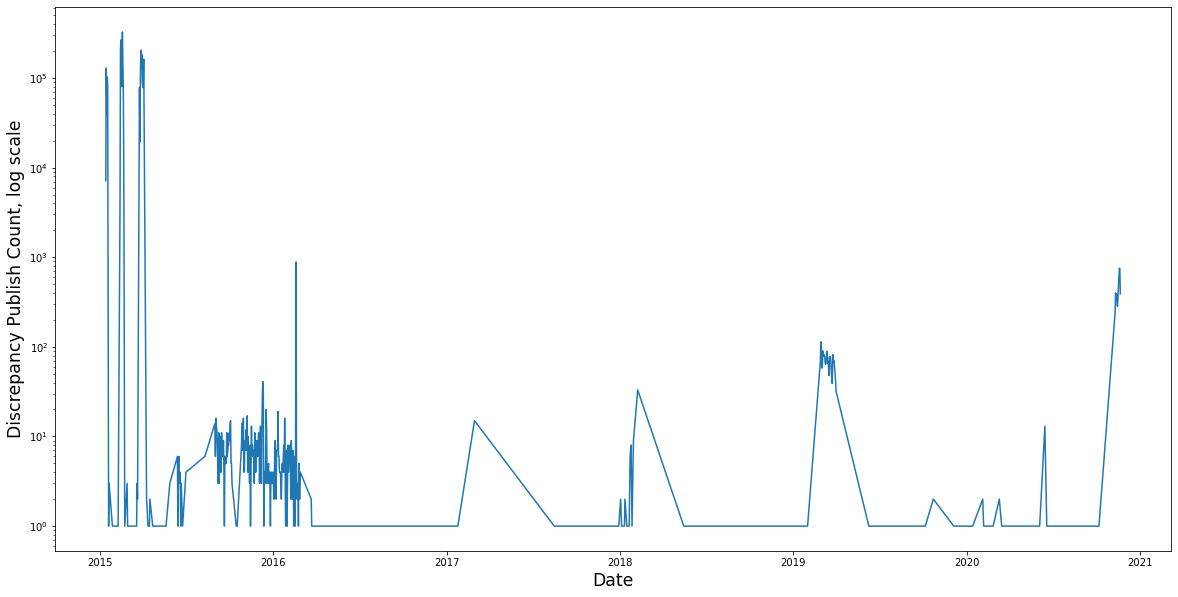

In [35]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.yscale('log')
plt.ylabel('Discrepancy Publish Count, log scale', **{'fontsize': 'xx-large'})
all_discrepancies_dates.value_counts().plot()

Just found there are some sites without canonical host.

In [36]:
sites_without_canonical_host = pd.read_csv(
	'./data/sites_to_copy_without_canonical_hosts.csv',
	names=['site_id']
)

In [37]:
sites_without_canonical_host.head()

,site_id
0,00189b66cbc74a67883914ad1ffa5f5e
1,003d4a7fea6c4c9ca08e6d81482319fb
2,0053dbe6b68f424e9f2ebd0fdc41407a
3,005c7231d7624b47979230feaa281d05
4,006756ebd93a435289392b6976bc54d9


In [38]:
set_sites_no_host = set(
	sites_without_canonical_host['site_id'].values.tolist())

Intersection of sites with no hosts with sites that miss artifacts counts
 that much items:

In [39]:
len(set_sites_no_host.intersection(set_sites_published_zips))

2901

Intersection of sites with no hosts with publishing discrepancies count that
 much items:

In [49]:
from itertools import islice
set_sites_discrepancy_ids = set(short_discrepancy.index.values.tolist())
list(islice(set_sites_discrepancy_ids, 10))

['8a4986cc2416d40701242adcb8ec7f83',
 '8a4986c843d7e1180143f261b42e5fcc',
 '8a4986ca380bb47e01380c3ba4c60cef',
 '57a3b5e622d241d5a46b2e9b2a146fec',
 '94677d9e23d54a7997b6bbb951d8d021',
 'a433df2c4d0d40dea2fa214f6248bb89',
 '8a4986ca302e0b4d01303aae40bb50d2',
 '8a4986ca2af939cd012afc6c7dfc1f37',
 'd5bd5d5dfbbd46fdbde4ef6994b70308',
 '8a4986c94080f2d0014093212caf3b56']

In [50]:
len(set_sites_no_host.intersection(set_sites_discrepancy_ids))

89

In [53]:
print(len(set_sites_published_zips))
print(len(set_sites_discrepancy_ids))
excluded_sites = set_sites_published_zips| set_sites_discrepancy_ids
len(excluded_sites)

5834000
7065


5834000

In [61]:
no_host_unknown = set_sites_no_host.difference(excluded_sites)
len(no_host_unknown)


231